In [ ]:
#Imports packages
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import keras
from keras import layers
import keras_tuner
from keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from dieboldmariano import dm_test
from scipy.stats import f_oneway

In [ ]:
#Reads and slices datasets, also converting DataFrames to Numpy arrays
datasets = {
    'data_1y': pd.read_csv('../data/processed/dataset_1y.csv').iloc[:, 1:].values,
    'data_5y': pd.read_csv('../data/processed/dataset_5y.csv').iloc[:, 1:].values,
    'data_binary': pd.read_csv('../data/processed/dataset_binary.csv').iloc[:, 1:].values,
    'data_neutral': pd.read_csv('../data/processed/dataset_neutral.csv').iloc[:, 1:].values,
    'data_so_pmi': pd.read_csv('../data/processed/dataset_so_pmi.csv').iloc[:, 1:].values
}

Trial 5 Complete [00h 00m 45s]
val_loss: 0.3955213129520416

Best val_loss So Far: 0.002139038173481822
Total elapsed time: 00h 05m 07s
Training time for data_so_pmi: 307.4234 seconds


c:\Users\furba\OneDrive\Pulpit\Praca Magisterska\SENTIMENT\venv\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0169 
Evaluation time for data_so_pmi: 0.6423 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 476ms/step
Prediction time for data_so_pmi: 0.9942 seconds


C:\Users\furba\AppData\Local\Temp\ipykernel_7044\3637633873.py:137: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


{'data_1y': {'Best Parameters': dict_items([('num_layers', 4), ('units_0', 256), ('activation', 'tanh'), ('l2', 0.005), ('dropout', True), ('units_1', 224), ('lr', 0.0008), ('units_2', 128), ('dropout_0', 0.1), ('dropout_1', 0.2), ('dropout_2', 0.2), ('units_3', 32), ('dropout_3', 0.1)]),
  'HUBER': 0.014103778637945652,
  'MAE': 103.95267169331397,
  'RMSE': 116.32230018937288,
  'Training Time': 365.568398475647,
  'Evaluation Time': 0.6812553405761719,
  'Prediction Time': 1.089066505432129},
 'data_5y': {'Best Parameters': dict_items([('num_layers', 3), ('units_0', 256), ('activation', 'relu'), ('l2', 0.001), ('dropout', True), ('units_1', 160), ('lr', 0.0008), ('dropout_0', 0.1), ('dropout_1', 0.2), ('units_2', 224), ('dropout_2', 0.2), ('units_3', 96), ('dropout_3', 0.1)]),
  'HUBER': 0.0019465491641312838,
  'MAE': 60.070015584520746,
  'RMSE': 76.8873260780382,
  'Training Time': 1245.0732662677765,
  'Evaluation Time': 0.71402907371521,
  'Prediction Time': 0.9715616703033447}

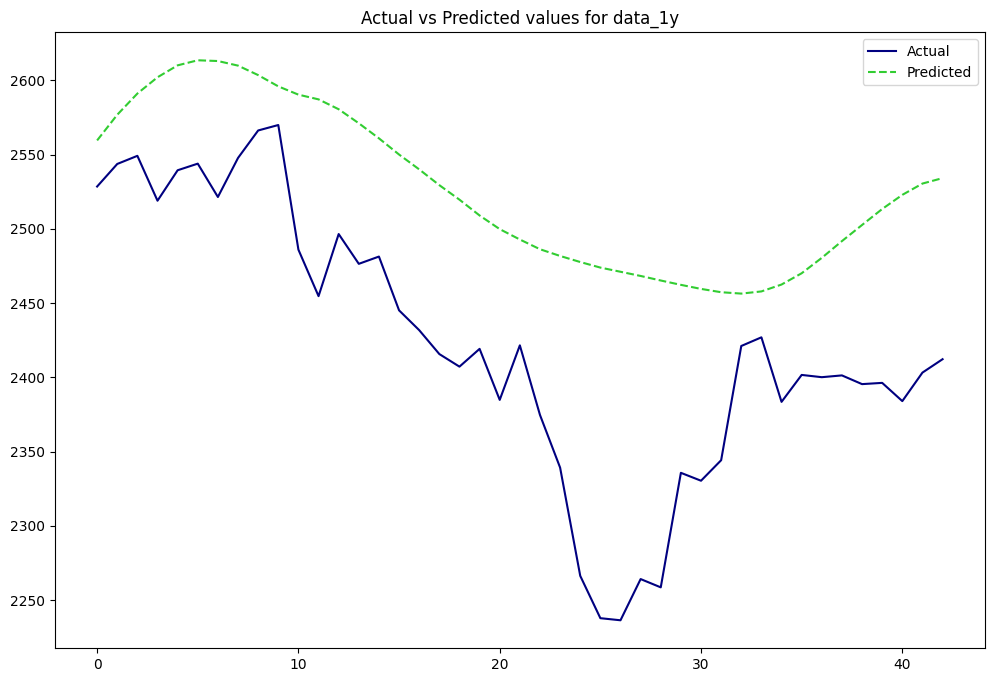

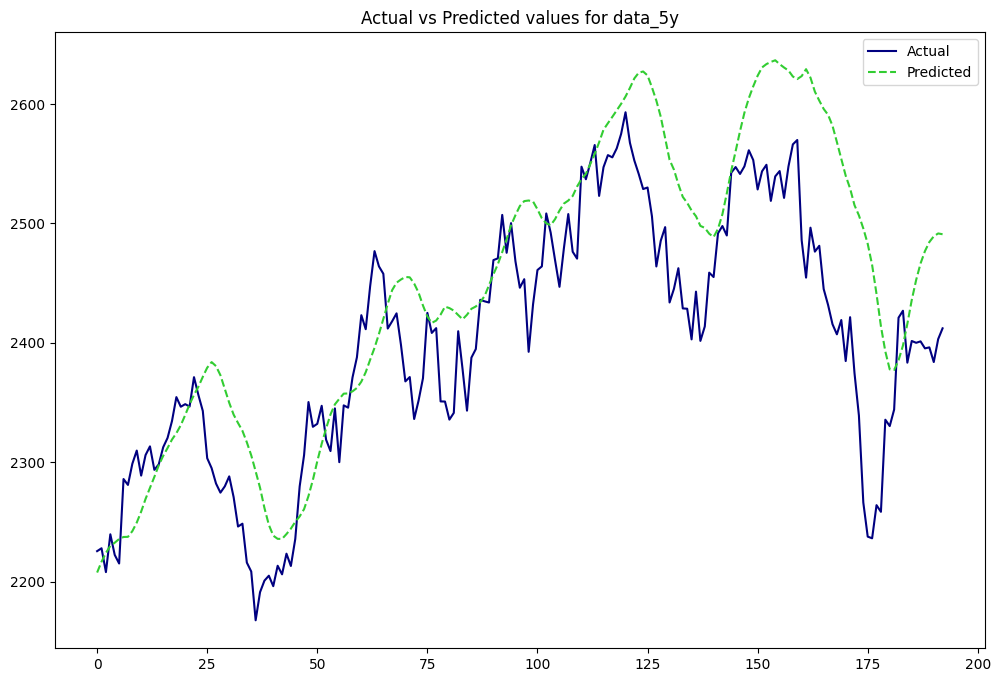

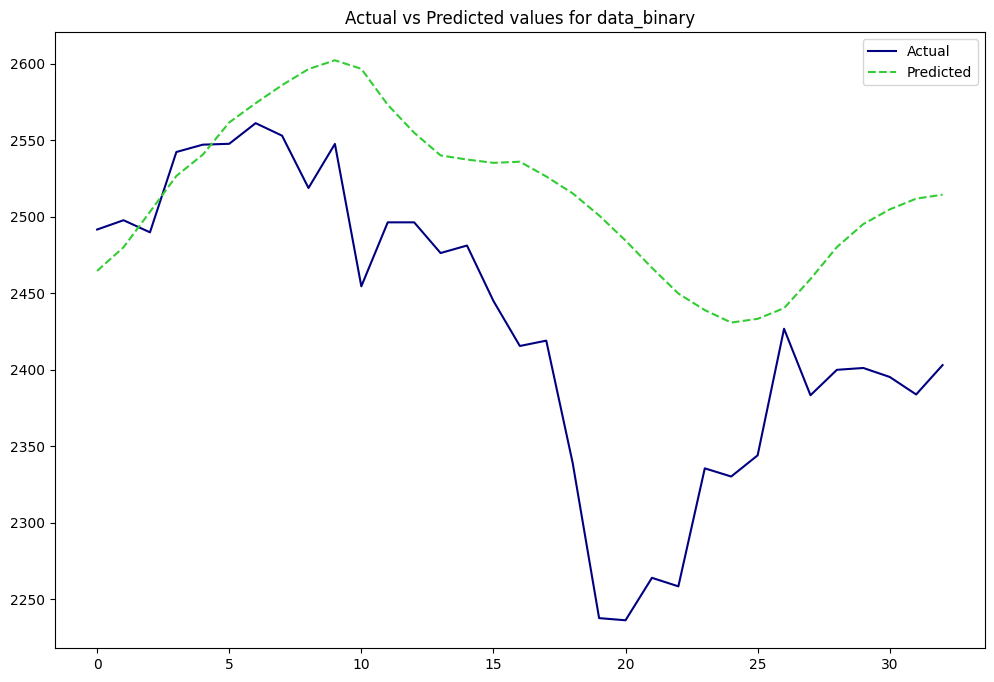

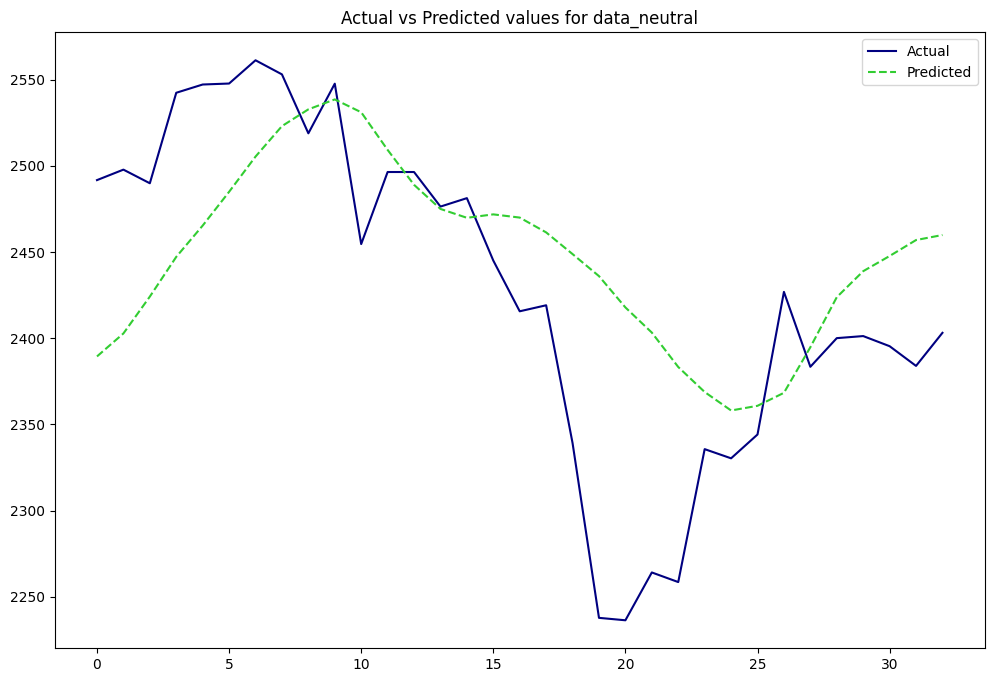

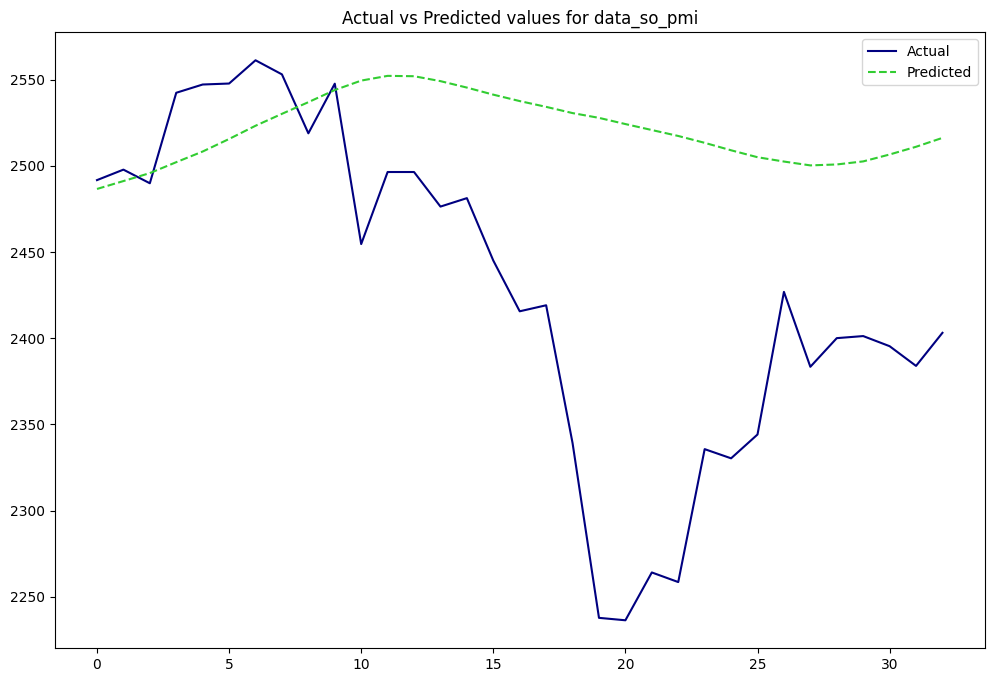

In [ ]:
#Sets number of days used as input
backcandles = 30
#Creates dictionary and list to store performance metrics and plots respectively
results_lstm = {}
plots_lstm = []

#Iterates over datasets
for name, data in datasets.items():
    
    X = [] #Placeholder for feature sequences
    num_columns = data.shape[1]-3 #Excludes columns with target variables

    #Generates sliding window sequences for feature columns
    for j in range(num_columns): #Loops over each feature column
        X.append([]) #Creates a new list in X
        for i in range(backcandles, data.shape[0]): #Starts from backacandles to the end
            #Creates a sequence of backcandles for feature column j
            X[j].append(data[i-backcandles:i, j]) #Appends window to column j's list
    
    #Moves axis to match LSTM required input shape    
    X = np.moveaxis(X, [0], [2])

    #Converts X to NumPy array and extracts target variable
    X, yi = np.array(X), np.array(data[backcandles:,-1])
    #Reshapes y to be a 2D array with one column
    y = np.reshape(yi,(len(yi),1))
    
    #Normalizes features and target variable
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    #Flattens X for scaling, then reshapes it back to original shape
    X_shape = X.shape
    X_reshaped = X.reshape(X_shape[0], -1)
    X_scaled = scaler_X.fit_transform(X_reshaped)
    X_scaled = X_scaled.reshape(X_shape)
    
    #Scales target variable
    y_scaled = scaler_y.fit_transform(y)
    
    #Splits data into training, validation, and test sets
    total_samples = len(X_scaled)
    train_limit = int(total_samples * 0.7)
    val_limit = int(total_samples * 0.85)
    X_train, X_val, X_test = X_scaled[:train_limit], X_scaled[train_limit:val_limit], X_scaled[val_limit:]
    y_train, y_val, y_test = y_scaled[:train_limit], y_scaled[train_limit:val_limit], y_scaled[val_limit:]
    
    # == Model builder for Keras Tuner ==
    def build_model(hp):
        #Initializes a Sequential model
        model = keras.Sequential()
        
        #Defines inout shape based on backcandles and number of features
        model.add(keras.Input(shape=(backcandles, X_train.shape[2])))
        
        #Randomly selects the number of LSTM layers between 2 and 4
        num_layers = hp.Int('num_layers', min_value=2, max_value=4)
        
        #Adds LSTM layers with hyperparameters tuned
        for i in range(num_layers):
            model.add(layers.LSTM(
                units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32), #Number of units in each layer
                activation=hp.Choice('activation', ['relu', 'tanh']), #Activation function
                return_sequences=(i < num_layers -1), #Returns sequences for all but the last layer
                recurrent_regularizer=l2(hp.Float("l2", min_value=0.001, max_value=0.01, step=5, sampling="log")) #L2 regularization for recurrent connections
            ))
            
            #Adds dropout layer if specified
            if hp.Boolean('dropout'):
                model.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.2, step=0.1))) #Dropout rate
         
        #Adds a dense layer with ReLu activation for regression output       
        model.add(layers.Dense(1, activation='relu'))
        
        #Compiles the model with Adam optimizer and Huber loss function
        model.compile(optimizer = keras.optimizers.Adam(
            learning_rate=hp.Float('lr', min_value=0.0001, max_value=0.001, step=2, sampling='log') #Tunes learning rate
            ), loss=Huber())
        
        return model #Returns the compiled model
    
    # == Keras Tuner setup  ==
    tuner = keras_tuner.BayesianOptimization(
        hypermodel = build_model,
        objective = 'val_loss', #Metric to optimize
        max_trials = 5,
        executions_per_trial = 1,
        overwrite = True,
        directory = 'lstm_directory',
        project_name = 'TUNER'
    )
    
    # == Callbacks for training ==
    #Stops training if validation loss does not improve for a specified number of epochs
    early_stopping = EarlyStopping(monitor='val_loss', patience=16, restore_best_weights=True)
    
    #Sets up TensorBoard for logging training metrics
    log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    #Reduces learning rate if validation loss does not improve for a specified number of epochs
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=0.0001,
        verbose=1
    )
    
    # == Hyperparameter search ==
    #records training start time
    start_time_train = time.time()
    
    #Starts the hyperparameter search
    tuner.search(
        X_train, y_train, 
        batch_size = 50, 
        epochs=120, 
        validation_data=(X_val, y_val), 
        callbacks=[early_stopping, tensorboard_callback, reduce_lr], 
        shuffle=True
    )
    
    #Calculates and prints training time
    training_time = time.time() - start_time_train
    print(f"Training time for {name}: {training_time:.4f} seconds")
    
    # == Evaluates and predicts with the best model ==
    best_model = tuner.get_best_models(num_models=1)[0]
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    start_time_eval = time.time()
    huber_loss = best_model.evaluate(X_test, y_test)
    eval_time = time.time() - start_time_eval
    print(f"Evaluation time for {name}: {eval_time:.4f} seconds")
    
    start_time_pred = time.time()
    y_pred_scaled = best_model.predict(X_test)
    predict_time = time.time() - start_time_pred
    print(f"Prediction time for {name}: {predict_time:.4f} seconds")
    
    # == Inverse scaling to get original values ==
    y_pred_original_lstm = scaler_y.inverse_transform(y_pred_scaled)
    y_test_original = scaler_y.inverse_transform(y_test)
    
    # == Calculates evaluation metrics ==
    mae = mean_absolute_error(y_test_original, y_pred_original_lstm)
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original_lstm))

    #Saves relevant results
    results_lstm[name] = {
        "Best Parameters": best_hp.values.items(),
        "HUBER": huber_loss,
        "MAE": mae,
        "RMSE": rmse,
        "Training Time": training_time,
        "Evaluation Time": eval_time,
        "Prediction Time": predict_time
    }

    # == Plots actual vs predicted values ==
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(y_test_original, color='navy', label='Actual')
    ax.plot(y_pred_original_lstm, color='limegreen', label='Predicted', linestyle='--')
    ax.set_title(f"Actual vs Predicted values for {name}")
    ax.legend()
    plots_lstm.append(fig)

#Shows all plots
for fig in plots_lstm:
    fig.show()

#Returns the results dictionary       
results_lstm

Training time for data_1y: 1.2919 seconds
Prediction time for data_1y: 0.0030 seconds


c:\Users\furba\OneDrive\Pulpit\Praca Magisterska\SENTIMENT\venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\furba\OneDrive\Pulpit\Praca Magisterska\SENTIMENT\venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\furba\OneDrive\Pulpit\Praca Magisterska\SENTIMENT\venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\furba\OneDrive\Pulpit\Praca Magisterska\SENTIMENT\venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScale

Training time for data_5y: 19.3397 seconds
Prediction time for data_5y: 0.0530 seconds
Training time for data_binary: 0.9120 seconds
Prediction time for data_binary: 0.0020 seconds
Training time for data_neutral: 0.8880 seconds
Prediction time for data_neutral: 0.0020 seconds
Training time for data_so_pmi: 0.8490 seconds
Prediction time for data_so_pmi: 0.0020 seconds


C:\Users\furba\AppData\Local\Temp\ipykernel_7044\508307822.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


{'data_1y': {'Best Parameters': {'C': 10,
   'epsilon': 0.01,
   'gamma': 0.01,
   'kernel': 'rbf',
   'max_iter': 10000},
  'MAE': 0.08358388036803449,
  'MAE (original)': 60.91509617341989,
  'Training Time': 1.2919437885284424,
  'Prediction Time': 0.002964019775390625},
 'data_5y': {'Best Parameters': {'C': 1,
   'epsilon': 0.001,
   'gamma': 0.01,
   'kernel': 'rbf',
   'max_iter': 10000},
  'MAE': 0.025419512389975116,
  'MAE (original)': 32.72431766548226,
  'Training Time': 19.339677572250366,
  'Prediction Time': 0.05300188064575195},
 'data_binary': {'Best Parameters': {'C': 1,
   'epsilon': 0.001,
   'gamma': 0.01,
   'kernel': 'rbf',
   'max_iter': 10000},
  'MAE': 0.08341517763318618,
  'MAE (original)': 60.79214730728975,
  'Training Time': 0.911998987197876,
  'Prediction Time': 0.002001047134399414},
 'data_neutral': {'Best Parameters': {'C': 1,
   'epsilon': 0.001,
   'gamma': 0.01,
   'kernel': 'rbf',
   'max_iter': 10000},
  'MAE': 0.07287900501517511,
  'MAE (origin

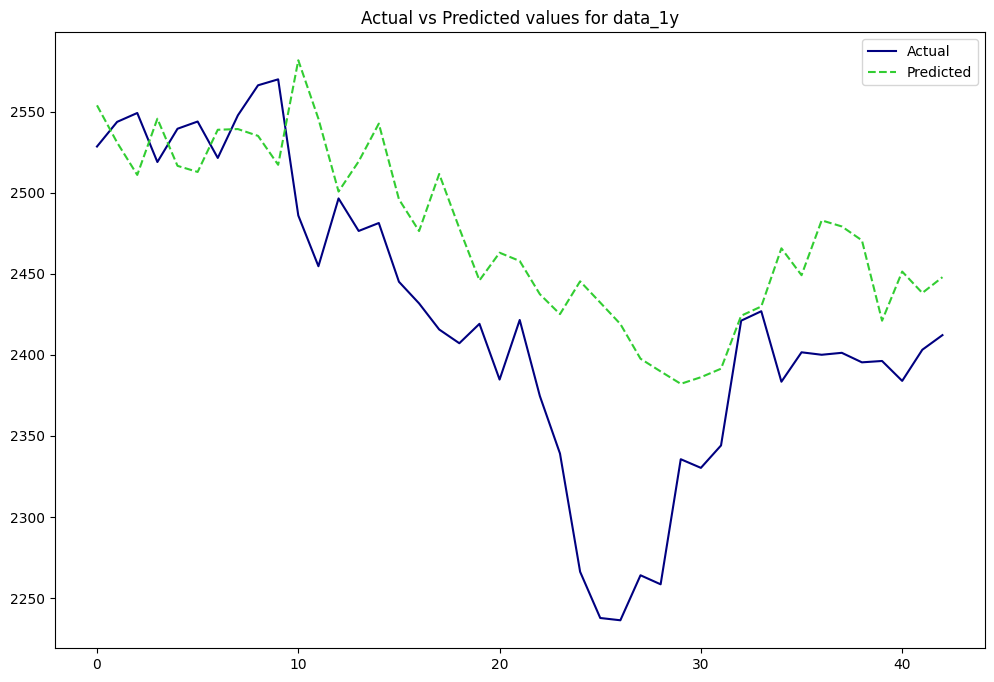

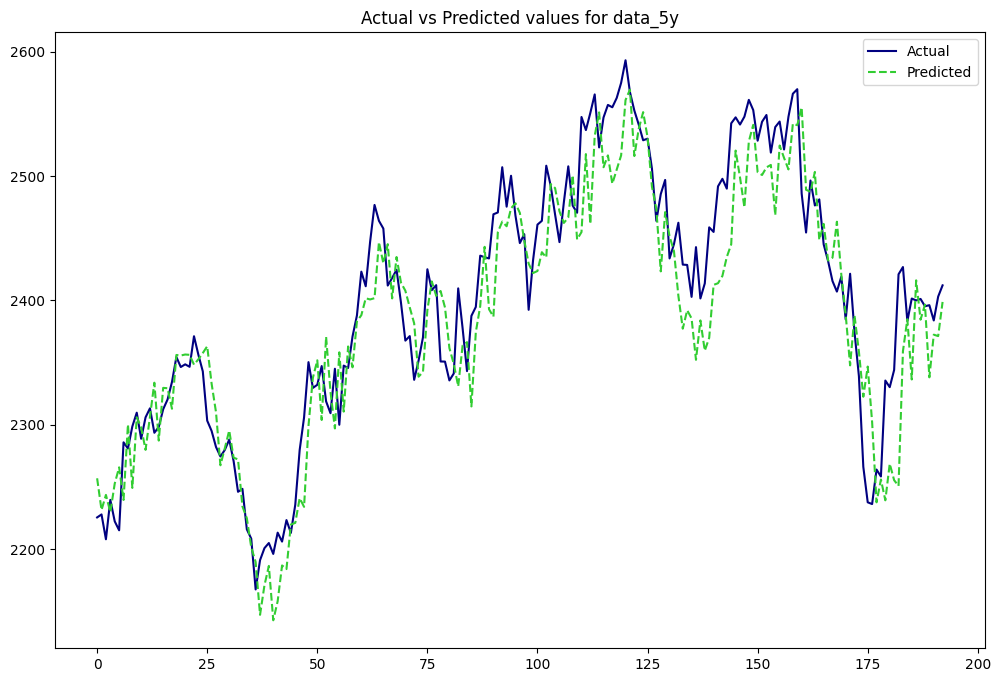

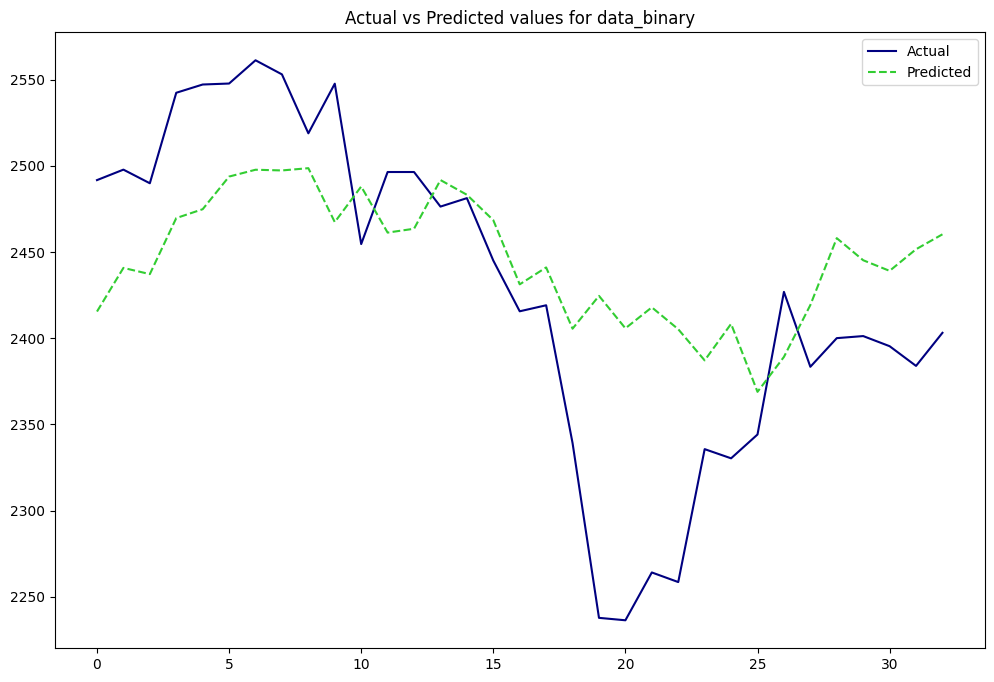

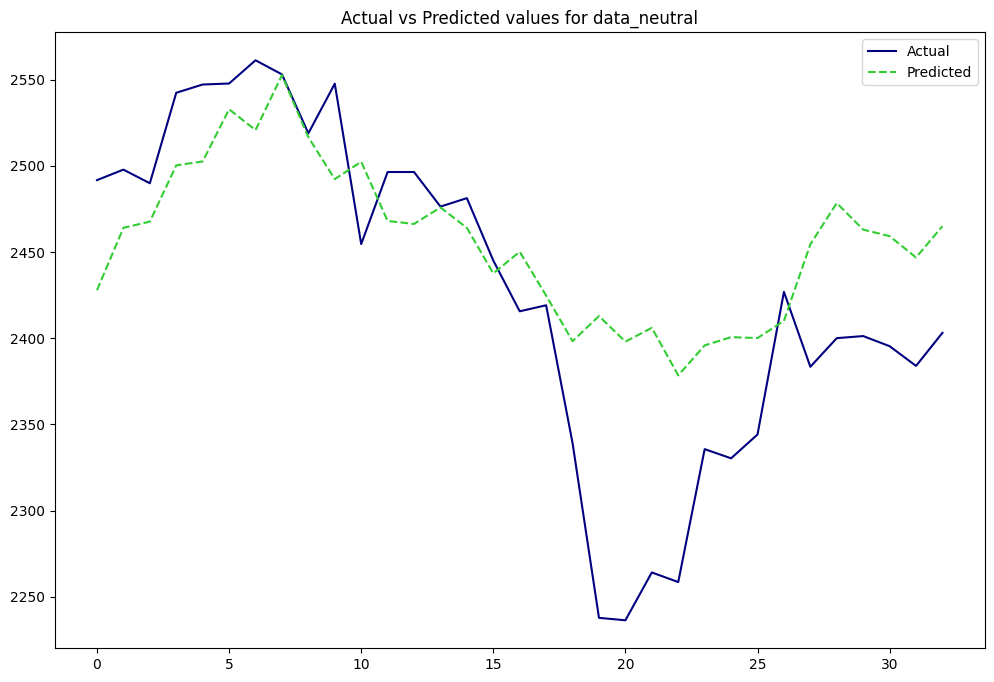

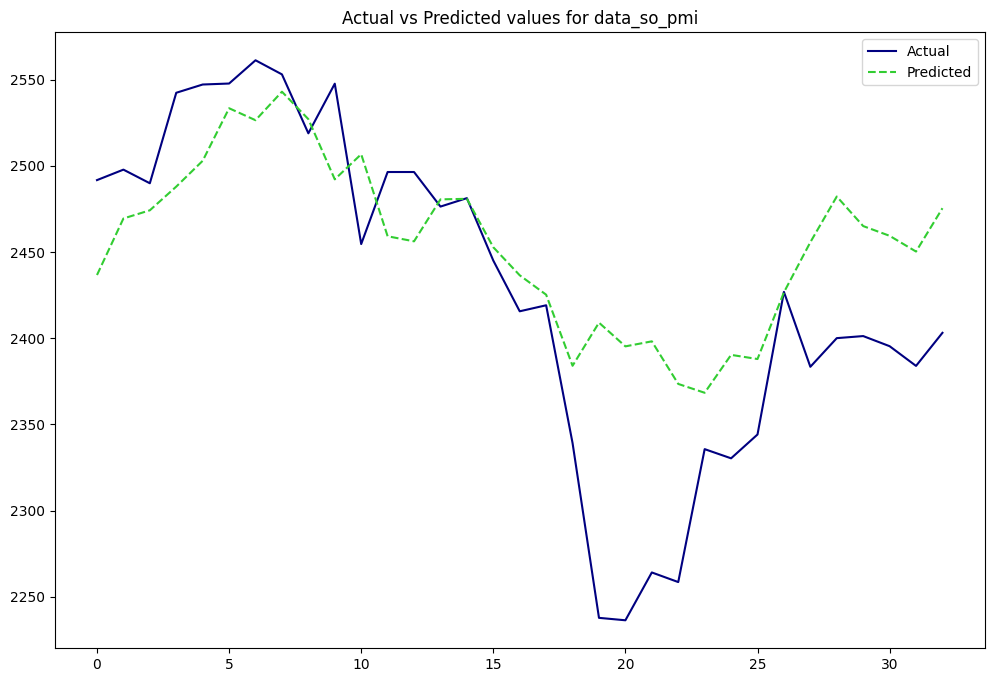

In [ ]:
#Sets number of days to be used as an input
backcandles = 30
#Creates dictionary and list to store performance metrics and plots respectively
results_svm = {}
plots_svm = []

#Iterates through all datasets
for name, data in datasets.items():
    
    X = [] #List to store feature sequences
    
    #Creates sliding window sequences for features
    for i in range(backcandles, data.shape[0]):
        #Flattens the 2D array of features into a 1D array to be compatible with SVR
        X.append(data[i-backcandles:i, :].flatten())
    
    #Converts ti NumPy arrays
    X, y = np.array(X), np.array(data[backcandles:,-1])
    
    #Scales features and target variable
    X_scaler = MinMaxScaler(feature_range=(0,1))
    X_scaled = X_scaler.fit_transform(X)
    y_scaler = MinMaxScaler(feature_range=(0, 1))
    y_scaled = y_scaler.fit_transform(y.reshape(-1,1)).ravel() #Flattens y to 1D after scaling
    
    #Splits data into training and test sets
    total_samples = len(X_scaled)
    train_limit = int(total_samples * 0.85)
    X_train, X_test = X_scaled[:train_limit], X_scaled[train_limit:]
    y_train, y_test = y_scaled[:train_limit], y_scaled[train_limit:]
    
    # == SVR model ==
    svr = SVR()
    
    # == Hyperparameter grid for SVR ==
    param_grid = {
        'kernel': ['rbf'], #Radial basis function kernel
        'C': [0.1, 1, 10], #Regularization parameter
        'epsilon': [0.001, 0.01, 0.1], #Epsilon parameter for SVR
        'gamma': ['scale', 0.01, 0.1, 1], #Kernel coefficient
        'max_iter': [10000] #Maximum number of iterations for convergence
    }
    
    # == Grid search Cross-Validation ==
    start_time_train = time.time()
    grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_absolute_error')
    grid_search.fit(X_train, y_train)
    training_time = time.time() - start_time_train
    print(f"Training time for {name}: {training_time:.4f} seconds")
    
    #Retrieves the best parameters from the grid search
    best_params = grid_search.best_params_
    
    # == Prediction ==
    start_time_pred = time.time()
    y_pred = grid_search.predict(X_test)
    prediction_time = time.time() - start_time_pred
    print(f"Prediction time for {name}: {prediction_time:.4f} seconds")
    
    #Calculates mean absolute error for scaled predictions
    mae_scaled = mean_absolute_error(y_test, y_pred)
    
    #Inverse scaling to get original values
    y_pred_original_svm = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
    y_test_original = y_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
    
    # Calculates mean absolute error for original predictions
    mae_original = mean_absolute_error(y_test_original, y_pred_original_svm)
    
    #Saves relevant results
    results_svm[name] = {
        "Best Parameters": best_params,
        "MAE": mae_scaled,
        "MAE (original)": mae_original,
        "Training Time": training_time,
        "Prediction Time": prediction_time
    }

    # == Plots actual vs predicted values ==
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(y_test_original, color='navy', label='Actual')
    ax.plot(y_pred_original_svm, color='limegreen', label='Predicted', linestyle='--')
    ax.set_title(f"Actual vs Predicted values for {name}")
    ax.legend()
    plots_svm.append(fig)

#Shows all plots
for fig in plots_svm:
    fig.show()

#Returns the results dictionary
results_svm

In [ ]:
#Flattens the arrays for error calculations
y_test_original = np.array(y_test_original).flatten()
y_pred_original_svm = np.array(y_pred_original_svm).flatten()
y_pred_original_lstm = np.array(y_pred_original_lstm).flatten()

#Calculates prediction errors (residuals)
svm_errors = y_test_original - y_pred_original_svm
lstm_errors = y_test_original - y_pred_original_lstm
#Calculates loss differentials
loss_differentials = np.abs(svm_errors) - np.abs(lstm_errors)

In [ ]:
for name, data in datasets.items(): #Loops through datasets
    if len(data.shape) > 1:
        data = data.flatten() #Flattens the data if it has more than one dimension
        
    results = acorr_ljungbox(data, lags=[30], return_df=True)  #Performs Ljung-Box test for autocorrelation
    
    #Prints the results of the Ljung-Box test
    print(f"{name}:")
    print(results)
    print( )

data_1y:
        lb_stat  lb_pvalue
30  8117.553436        0.0

data_5y:
        lb_stat  lb_pvalue
30  36645.94003        0.0

data_binary:
        lb_stat  lb_pvalue
30  6756.181073        0.0

data_neutral:
        lb_stat  lb_pvalue
30  6756.181073        0.0

data_so_pmi:
        lb_stat  lb_pvalue
30  6756.181074        0.0



In [ ]:
#Performs the Augmented Dickey-Fuller test for stationarity on loss differentials
adf_stat, p_val, _, _, _, _ = adfuller(loss_differentials)
# Prints the ADF statistic and p-value
print(f"ADF Statistic: {adf_stat}, p-value: {p_val}")

# Checks if the p-value is less than 0.05 to determine stationarity
if p_val < 0.05:
    print("Loss differentials are stationary.")
else:
    print("Loss differentials are non-stationary.")

ADF Statistic: -1.7210764058683627, p-value: 0.42028729736431303
Loss differentials are non-stationary.


In [ ]:
#Performs the Diebold-Mariano test for forecast accuracy comparison
dm_stat, p_value = dm_test(y_test_original, svm_errors, lstm_errors, h=1, one_sided=False)

#Prints the Diebold-Mariano statistic and p-value
print(f"Diebold-Mariano Statistic: {dm_stat}")
print(f"P-Value: {p_value}")

#Checks if the p-value is less than 0.05 to determine if the models have significantly different forecast accuracy
if p_value < 0.05:
    print("The two models have significantly different forecast accuracy.")
else:
    print("The two models have similar forecast accuracy.")

Diebold-Mariano Statistic: -7.779094955328812
P-Value: 7.156156674667804e-09
The two models have significantly different forecast accuracy.


In [ ]:
#Calculates the observed mean difference of loss differentials
observed_mean_diff = np.mean(loss_differentials)

num_permutations = 10000 #Number of permutations for the test
permuted_differences = [] #List to store permuted mean differences

#Loops through the number of permutations
for _ in range(num_permutations):
    #Shuffles the loss differentials by randomly multiplying by -1 or 1
    shuffled_differentials = loss_differentials * np.random.choice([-1, 1], size=len(loss_differentials))
    permuted_mean_diff = np.mean(shuffled_differentials) #Calculates the mean of the shuffled differentials
    permuted_differences.append(permuted_mean_diff) #Adds the permuted mean difference to the list

#Converts the list of permuted differences to a NumPy array
permuted_differences = np.array(permuted_differences)

#Calculates the p-value by comparing the absolute values of permuted differences to the observed mean difference
p_value = np.mean(np.abs(permuted_differences) >= np.abs(observed_mean_diff))

#Prints the observed mean difference and p-value
print(f"Observed mean difference: {observed_mean_diff}")
print(f"P-value: {p_value}")


Observed mean difference: -53.48558944659987
P-value: 0.0


In [ ]:
#Loops through datasets to perform ANOVA
for name, data in datasets.items():
    print(f"\nPerforming ANOVA for {name}...".ljust(40))
    
    #Checks if data has more than one column
    if data.shape[1] > 1:
        #Performs ANOVA test on the columns of the dataset
        f_stat, p_value = f_oneway(*[data[:, col] for col in range(data.shape[1])])
        # Prints the F-statistic and p-value
        print(f"F-Statistic: {f_stat:.4f}, P-Value: {p_value:.4e}")
        
        #Checks if the p-value is less than 0.05 to determine significance
        if p_value < 0.05:
            print("Significant difference between groups")
        else:
            print("No significant difference between groups)")


Performing ANOVA for data_1y...        
F-Statistic: 32.3893, P-Value: 6.4981e-78
Significant difference between groups

Performing ANOVA for data_5y...        
F-Statistic: 402.7694, P-Value: 0.0000e+00
Significant difference between groups

Performing ANOVA for data_binary...    
F-Statistic: 26.2319, P-Value: 3.2743e-66
Significant difference between groups

Performing ANOVA for data_neutral...   
F-Statistic: 26.2319, P-Value: 3.2743e-66
Significant difference between groups

Performing ANOVA for data_so_pmi...    
F-Statistic: 26.2319, P-Value: 3.2743e-66
Significant difference between groups


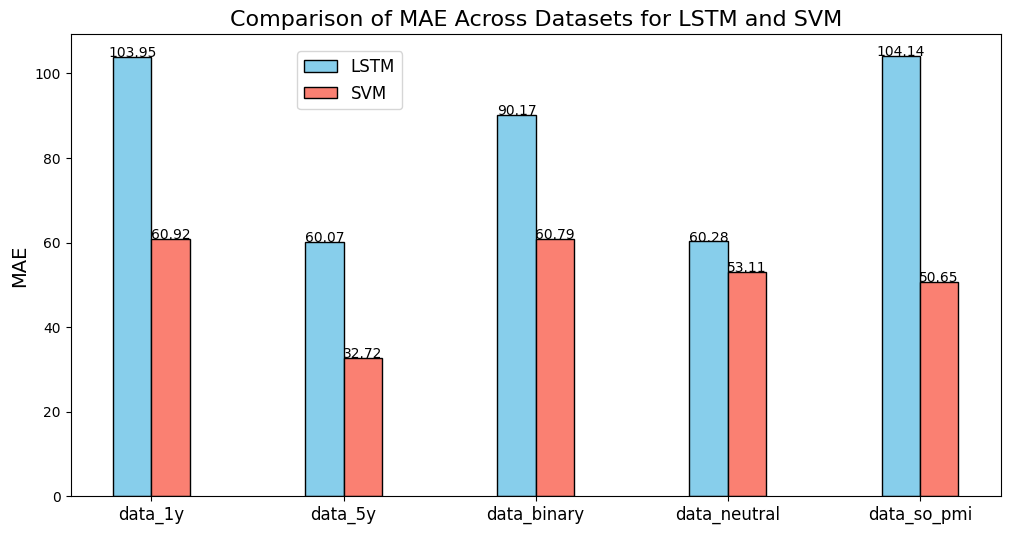

In [ ]:
#Extracts dataset names and MAE values for each dataset for LSTM and SVM
dataset_names = list(results_lstm.keys())
mae_values_lstm = [results_lstm[name]["MAE"] for name in dataset_names]
mae_values_svm = [results_svm[name]["MAE (original)"] for name in dataset_names]

#Plots the comparison of MAE across datasets for LSTM and SVM
plt.figure(figsize=(12, 6))
x = np.arange(len(dataset_names))
bar_width = 0.20
plt.bar(x - bar_width/2, mae_values_lstm, bar_width, label='LSTM', color='skyblue', edgecolor='black')
plt.bar(x + bar_width/2, mae_values_svm, bar_width, label='SVM', color='salmon', edgecolor='black')
plt.xticks(x, dataset_names, rotation=0, fontsize=12)
plt.ylabel('MAE', fontsize=14)
plt.title('Comparison of MAE Across Datasets for LSTM and SVM', fontsize=16)
plt.legend(fontsize=12, bbox_to_anchor=(0.3, 0.9), loc='center')

#Annotates the bars with MAE values
for i, (lstm_mae, svm_mae) in enumerate(zip(mae_values_lstm, mae_values_svm)):
    plt.text(i - bar_width/2, lstm_mae + 0.01, f"{lstm_mae:.2f}", ha='center', fontsize=10)
    plt.text(i + bar_width/2, svm_mae + 0.01, f"{svm_mae:.2f}", ha='center', fontsize=10)

#Displays the plot
plt.show()